# Correlation and Diversification #

In [430]:
# Import Libraries

# Data Management
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt

# Optiminization
import statsmodels.api as sm 
from scipy.optimize import minimize

# Pretty Notation
from IPython.display import display, Math

In [431]:
def import_financial_data(
    ticker: str
):

    # Check the ticker for Upper Cases
    ticker = ticker if ticker.isupper() else ticker.upper()

    # Import data
    df = pd.read_csv(rf"..\stocks\{ticker}.csv")

    # Set the Index
    df = df.set_index('Date')
    df.index = pd.to_datetime(df.index)

    df_useful_data = df[['Open Price', 'High Price', 'Low Price', 'Close Price']]

    df_useful_data = df_useful_data.rename(columns={
        "Open Price":"Open",
        "High Price":"High",
        "Low Price":"Low",
        "Close Price":"Close",
    })

    # Drop NaN's
    df_useful_data.dropna(inplace = True)

    return df_useful_data.loc["2015-01-01":]

### Benefits of Diversification ###

In [433]:
# Import Data

# Apple Data
df_1 = import_financial_data("AAPL")

# Amazon Data
df_2 =  import_financial_data("AMZN")

# Meta Data
df_3 =  import_financial_data("META")

# Microsoft Data
df_4 =  import_financial_data("MSFT")

# Walmart Data
df_5 =  import_financial_data("WMT")

In [434]:
# Create the joint dataframe

df_data = pd.DataFrame()

df_data['AAPL'] = df_1['Close']
df_data['AMZN'] = df_2['Close']
df_data['META'] = df_3['Close']
df_data['MSFT'] = df_4['Close']
df_data['WMT'] = df_5['Close']

df_data = df_data.dropna()

df_returns = df_data.pct_change(1).dropna()

df_returns

,AAPL,AMZN,META,MSFT,WMT
Date,,,,,
2015-01-05,-0.028172,-0.020517,-0.016061,-0.009303,-0.002910
2015-01-06,0.000094,-0.022833,-0.013473,-0.014571,0.007706
2015-01-07,0.014022,0.010600,0.000000,0.012705,0.026532
2015-01-08,0.038422,0.006836,0.026592,0.029418,0.021106
2015-01-09,0.001072,-0.011749,-0.005564,-0.008405,-0.012380
...,...,...,...,...,...
2024-10-22,-0.002622,0.003332,0.011910,0.020846,0.014973
2024-10-23,-0.021623,-0.026305,-0.031477,-0.006807,0.015240
2024-10-24,-0.000823,0.009041,0.007256,0.000306,-0.002762


In [435]:
# Theoretically we could use the average as the expected returns (these are daily returns)

expected_returns = df_returns.mean() * 252

expected_returns

AAPL    0.259835
AMZN    0.308792
META    0.275418
MSFT    0.262559
WMT     0.130698
dtype: float64

In [436]:
# The volatility is calculated with the standard deviations (also daily volatilities)

volat = df_returns.dropna().std() * np.sqrt(252)

volat

AAPL    0.286456
AMZN    0.327854
META    0.376397
MSFT    0.272155
WMT     0.211951
dtype: float64

In [437]:
# Covariance Matrix

cov_matrix = df_returns.dropna().cov() * 252

cov_matrix

,AAPL,AMZN,META,MSFT,WMT
AAPL,0.082057,0.052244,0.056819,0.053274,0.018882
AMZN,0.052244,0.107488,0.072950,0.058608,0.017443
META,0.056819,0.072950,0.141674,0.059643,0.015537
MSFT,0.053274,0.058608,0.059643,0.074068,0.019539
WMT,0.018882,0.017443,0.015537,0.019539,0.044923


In [438]:
# Create the Equal Weighted Portfolio

n_assets = 5
weights = np.array([1/n_assets] * n_assets)  # Equal weights

weights

array([0.2, 0.2, 0.2, 0.2, 0.2])

In [439]:
# Portfolio expected return
portfolio_return = np.dot(weights, expected_returns)

# Portfolio variance and volatility
portfolio_variance = np.dot(weights.T, np.dot(cov_matrix, weights))
portfolio_volatility = np.sqrt(portfolio_variance)

print("\nPortfolio Expected Return:", portfolio_return)
print("Portfolio Volatility:", portfolio_volatility)


Portfolio Expected Return: 0.24746025653288214
Portfolio Volatility: 0.2280425314805113


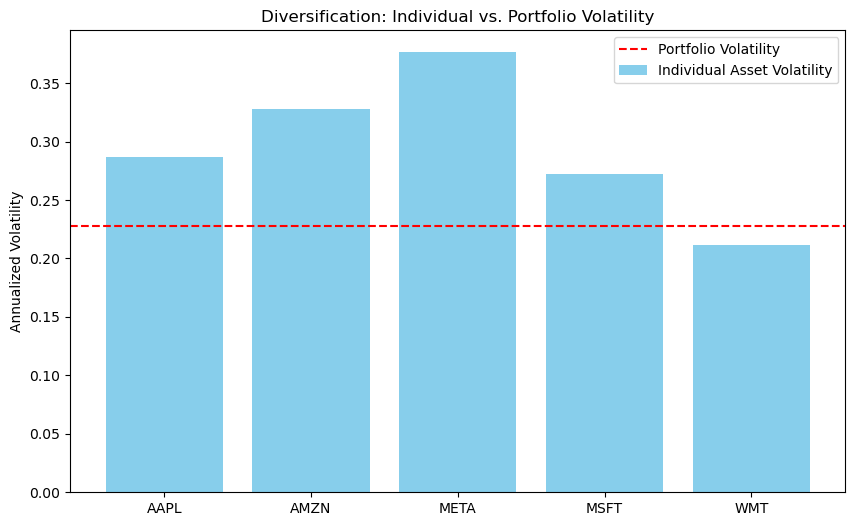

In [440]:
# Plot the Volatilities

plt.figure(figsize=(10, 6))
plt.bar(df_data.columns, volat, color='skyblue', label='Individual Asset Volatility')
plt.axhline(y=portfolio_volatility, color='red', linestyle='--', label='Portfolio Volatility')
plt.ylabel('Annualized Volatility')
plt.title('Diversification: Individual vs. Portfolio Volatility')
plt.legend()
plt.show()

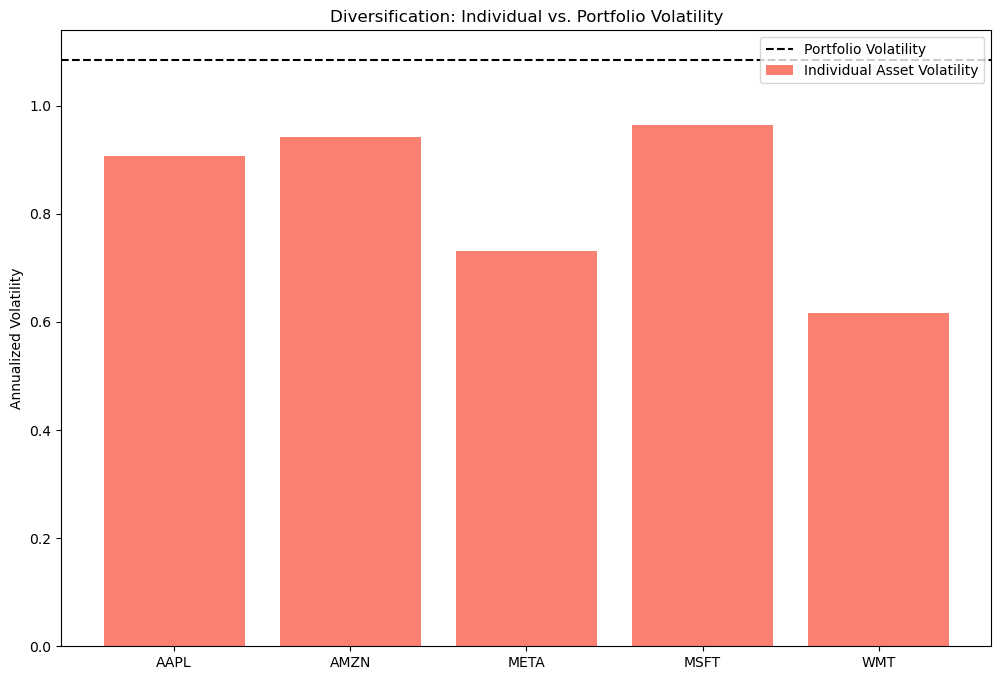

In [441]:
# Efficiency Ratios

eff_ratios = expected_returns/volat
portafolio_effciency = portfolio_return/portfolio_volatility

plt.figure(figsize=(12, 8))
plt.bar(df_data.columns, eff_ratios, color='salmon', label='Individual Asset Volatility')
plt.axhline(y=portafolio_effciency, color='black', linestyle='--', label='Portfolio Volatility')
plt.ylabel('Annualized Volatility')
plt.title('Diversification: Individual vs. Portfolio Volatility')
plt.legend()
plt.show()

In [442]:
# Adjusted Returns

print(f"Portfolio Risk-Adjusted Returns: {portafolio_effciency}")
print(f"Stocks Risk-Adjusted Returns:\n{eff_ratios}")

Portfolio Risk-Adjusted Returns: 1.085149576819315
Stocks Risk-Adjusted Returns:
AAPL    0.907067
AMZN    0.941857
META    0.731723
MSFT    0.964741
WMT     0.616642
dtype: float64


### The Correlation ###

In [444]:
# Correlation is the Scale of Covariance [-1, 1]

pearson = df_returns.corr()

pearson

,AAPL,AMZN,META,MSFT,WMT
AAPL,1.000000,0.556280,0.526970,0.683344,0.310992
AMZN,0.556280,1.000000,0.591155,0.656836,0.251019
META,0.526970,0.591155,1.000000,0.582232,0.194750
MSFT,0.683344,0.656836,0.582232,1.000000,0.338721
WMT,0.310992,0.251019,0.194750,0.338721,1.000000


In [445]:
# Non Linear Correlations

spearman = df_returns.corr(method='spearman')

spearman

,AAPL,AMZN,META,MSFT,WMT
AAPL,1.000000,0.567944,0.518927,0.635808,0.262510
AMZN,0.567944,1.000000,0.612027,0.658440,0.259692
META,0.518927,0.612027,1.000000,0.590644,0.203536
MSFT,0.635808,0.658440,0.590644,1.000000,0.302011
WMT,0.262510,0.259692,0.203536,0.302011,1.000000


In [446]:
# Letus get the CAPM residuals

capm_residuals = pd.read_csv(r'..\additional_data\capm_residuals.csv')
capm_residuals = capm_residuals.set_index('Date')
capm_residuals.index = pd.to_datetime(capm_residuals.index)

# Just the stocks we need
capm_residuals = capm_residuals[df_returns.columns]

capm_residuals

,AAPL,AMZN,META,MSFT,WMT
Date,,,,,
2015-01-06,0.010770,-0.012257,-0.001538,-0.003811,0.011993
2015-01-07,0.000086,-0.003207,-0.015565,-0.001339,0.020861
2015-01-08,0.016982,-0.014406,0.002643,0.007810,0.012397
2015-01-09,0.011161,-0.001754,0.005714,0.001763,-0.008330
2015-01-12,-0.014924,-0.008964,-0.002258,-0.002710,0.011399
...,...,...,...,...,...
2024-10-22,-0.002030,0.003918,0.012585,0.021444,0.015145
2024-10-23,-0.010578,-0.015363,-0.019122,0.004326,0.019641
2024-10-24,-0.003374,0.006513,0.004420,-0.002263,-0.003862


In [447]:
capm_residuals.corr()

,AAPL,AMZN,META,MSFT,WMT
AAPL,1.000000,0.168733,0.138673,0.213623,-0.021978
AMZN,0.168733,1.000000,0.343176,0.335798,-0.027054
META,0.138673,0.343176,1.000000,0.205438,-0.094474
MSFT,0.213623,0.335798,0.205438,1.000000,-0.011156
WMT,-0.021978,-0.027054,-0.094474,-0.011156,1.000000


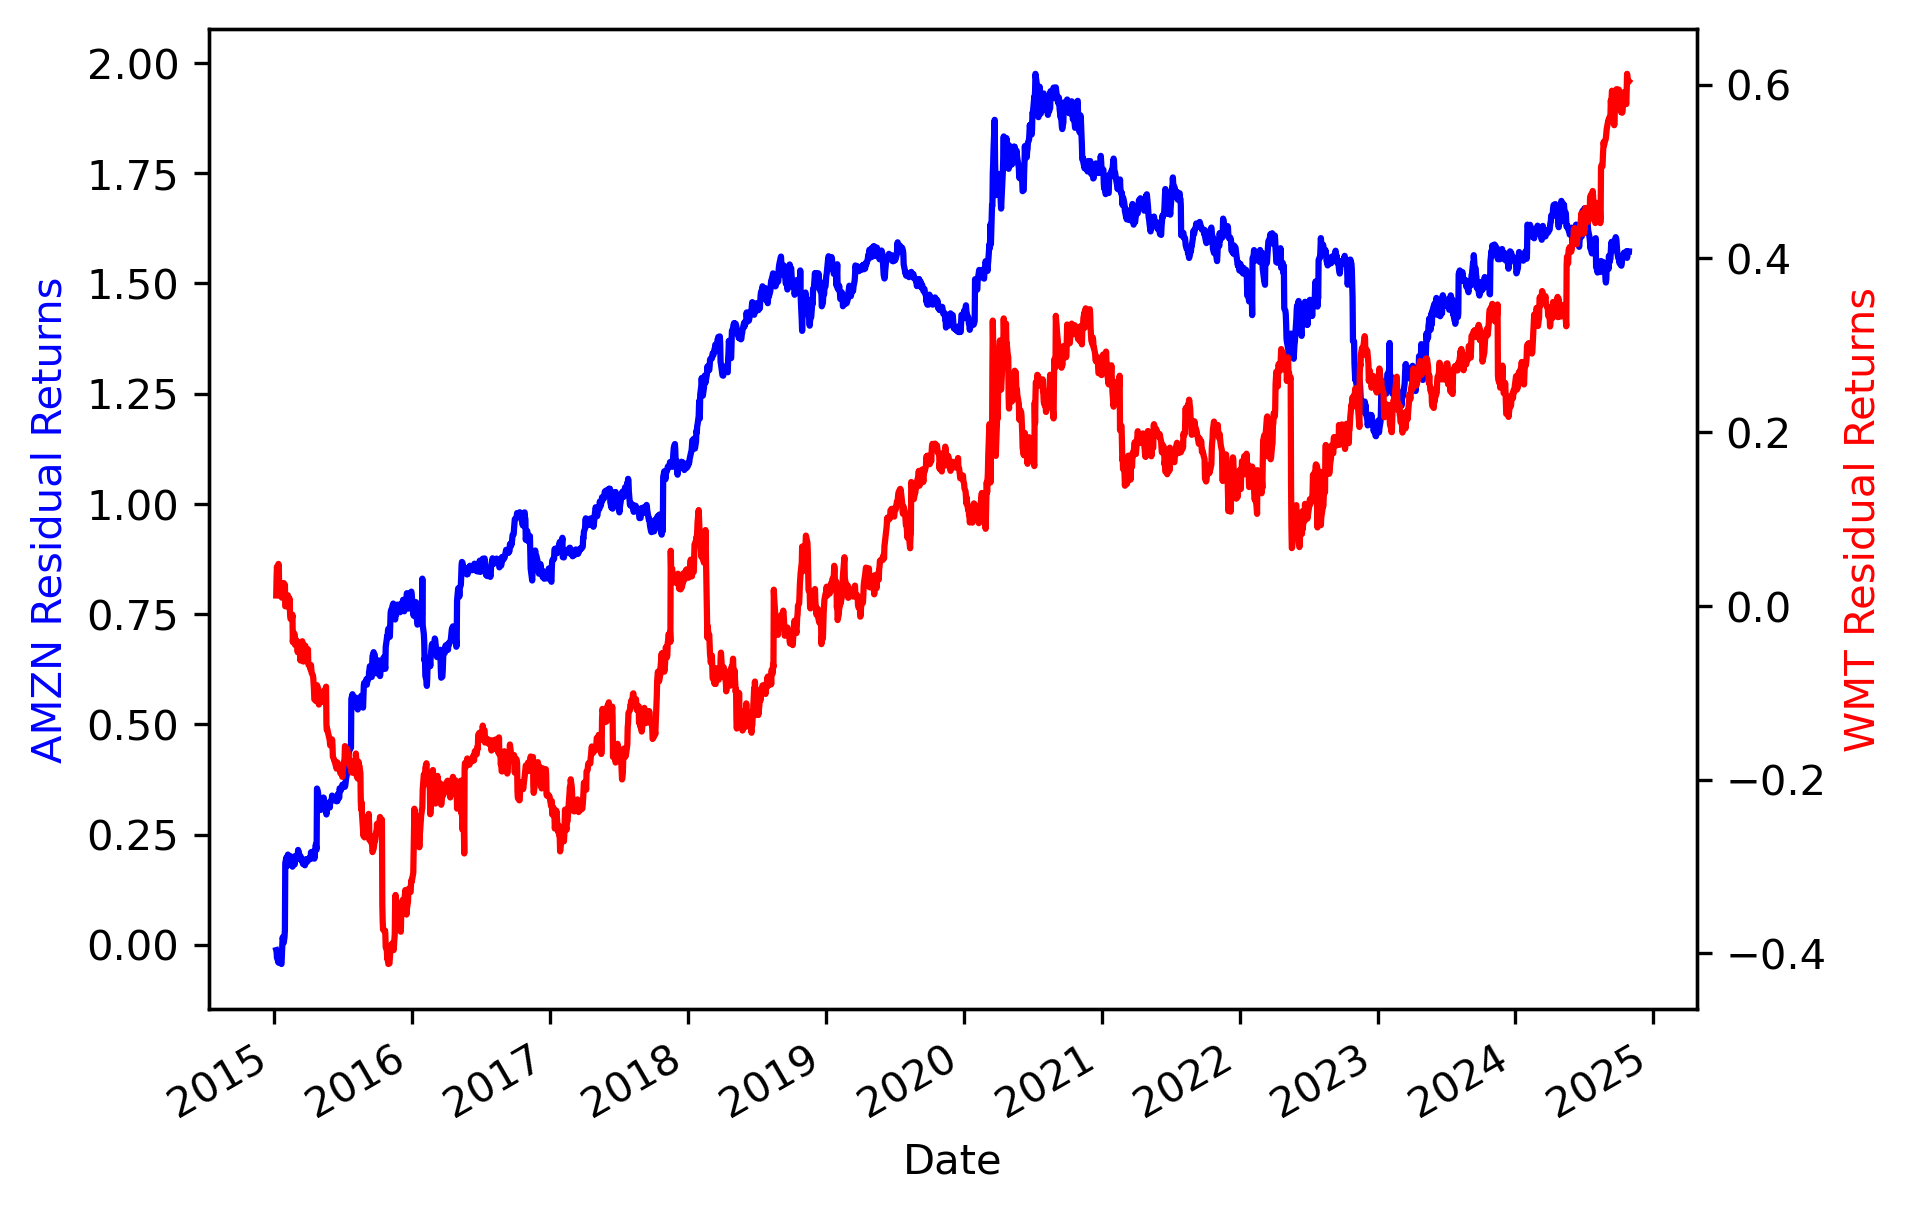

In [448]:
# Create Figure
fig, ax1 = plt.subplots(dpi = 300)

# AMZN Residual Returns
capm_residuals['AMZN'].cumsum().plot(color = 'blue', ax = ax1)
ax1.set_xlabel('Date')
ax1.set_ylabel(
    'AMZN Residual Returns', 
    color='blue'
    )

# WMT Residual Returns
ax2 = ax1.twinx()

capm_residuals['WMT'].cumsum().plot(color = 'red', ax = ax2)
ax2.set_ylabel(
    'WMT Residual Returns', 
    color='red'
    )

plt.show()

In [449]:
def detrending_series(
        y: pd.Series(),
        residuals=True
):
    Y = y.dropna()

    trend = pd.Series(
        np.arange(1, len(Y) + 1),
        index=Y.index
    )

    models = [
        sm.OLS(Y, sm.add_constant(np.ones_like(Y))),
        sm.OLS(Y, sm.add_constant(trend)),
        sm.OLS(Y, sm.add_constant(pd.DataFrame({"trend": trend, "trend_sq": trend ** 2}))),
        # sm.OLS(Y, sm.add_constant(pd.DataFrame({"trend": trend, "trend_sq": trend ** 2, "trend_cb": trend ** 3}))),
        # sm.OLS(Y, sm.add_constant(
        #    pd.DataFrame({"trend": trend, "trend_sq": trend ** 2, "trend_cb": trend ** 3, "trend_qua": trend ** 4}))),
    ]

    results = [model.fit() for model in models]
    aics = [result.aic for result in results]

    best_model_index = np.argmin(aics)
    best_result = results[best_model_index]

    # print(best_result.summary())

    if residuals:
        return best_result.resid

    else:
        return best_result.fittedvalues

In [450]:
# Let us detrend

cumsum_detrended = capm_residuals.cumsum().apply(detrending_series)

cumsum_detrended

,AAPL,AMZN,META,MSFT,WMT
Date,,,,,
2015-01-06,0.135964,-0.243667,-0.245739,0.161481,0.263133
2015-01-07,0.135493,-0.248577,-0.261501,0.159231,0.283726
2015-01-08,0.151917,-0.264685,-0.259057,0.166131,0.295855
2015-01-09,0.162521,-0.268140,-0.253541,0.166984,0.287257
2015-01-12,0.147039,-0.278805,-0.255997,0.163365,0.298387
...,...,...,...,...,...
2024-10-22,-0.183242,0.227282,0.376604,-0.130043,0.187260
2024-10-23,-0.194377,0.212713,0.357283,-0.125957,0.206632
2024-10-24,-0.198309,0.220020,0.361504,-0.128460,0.202502


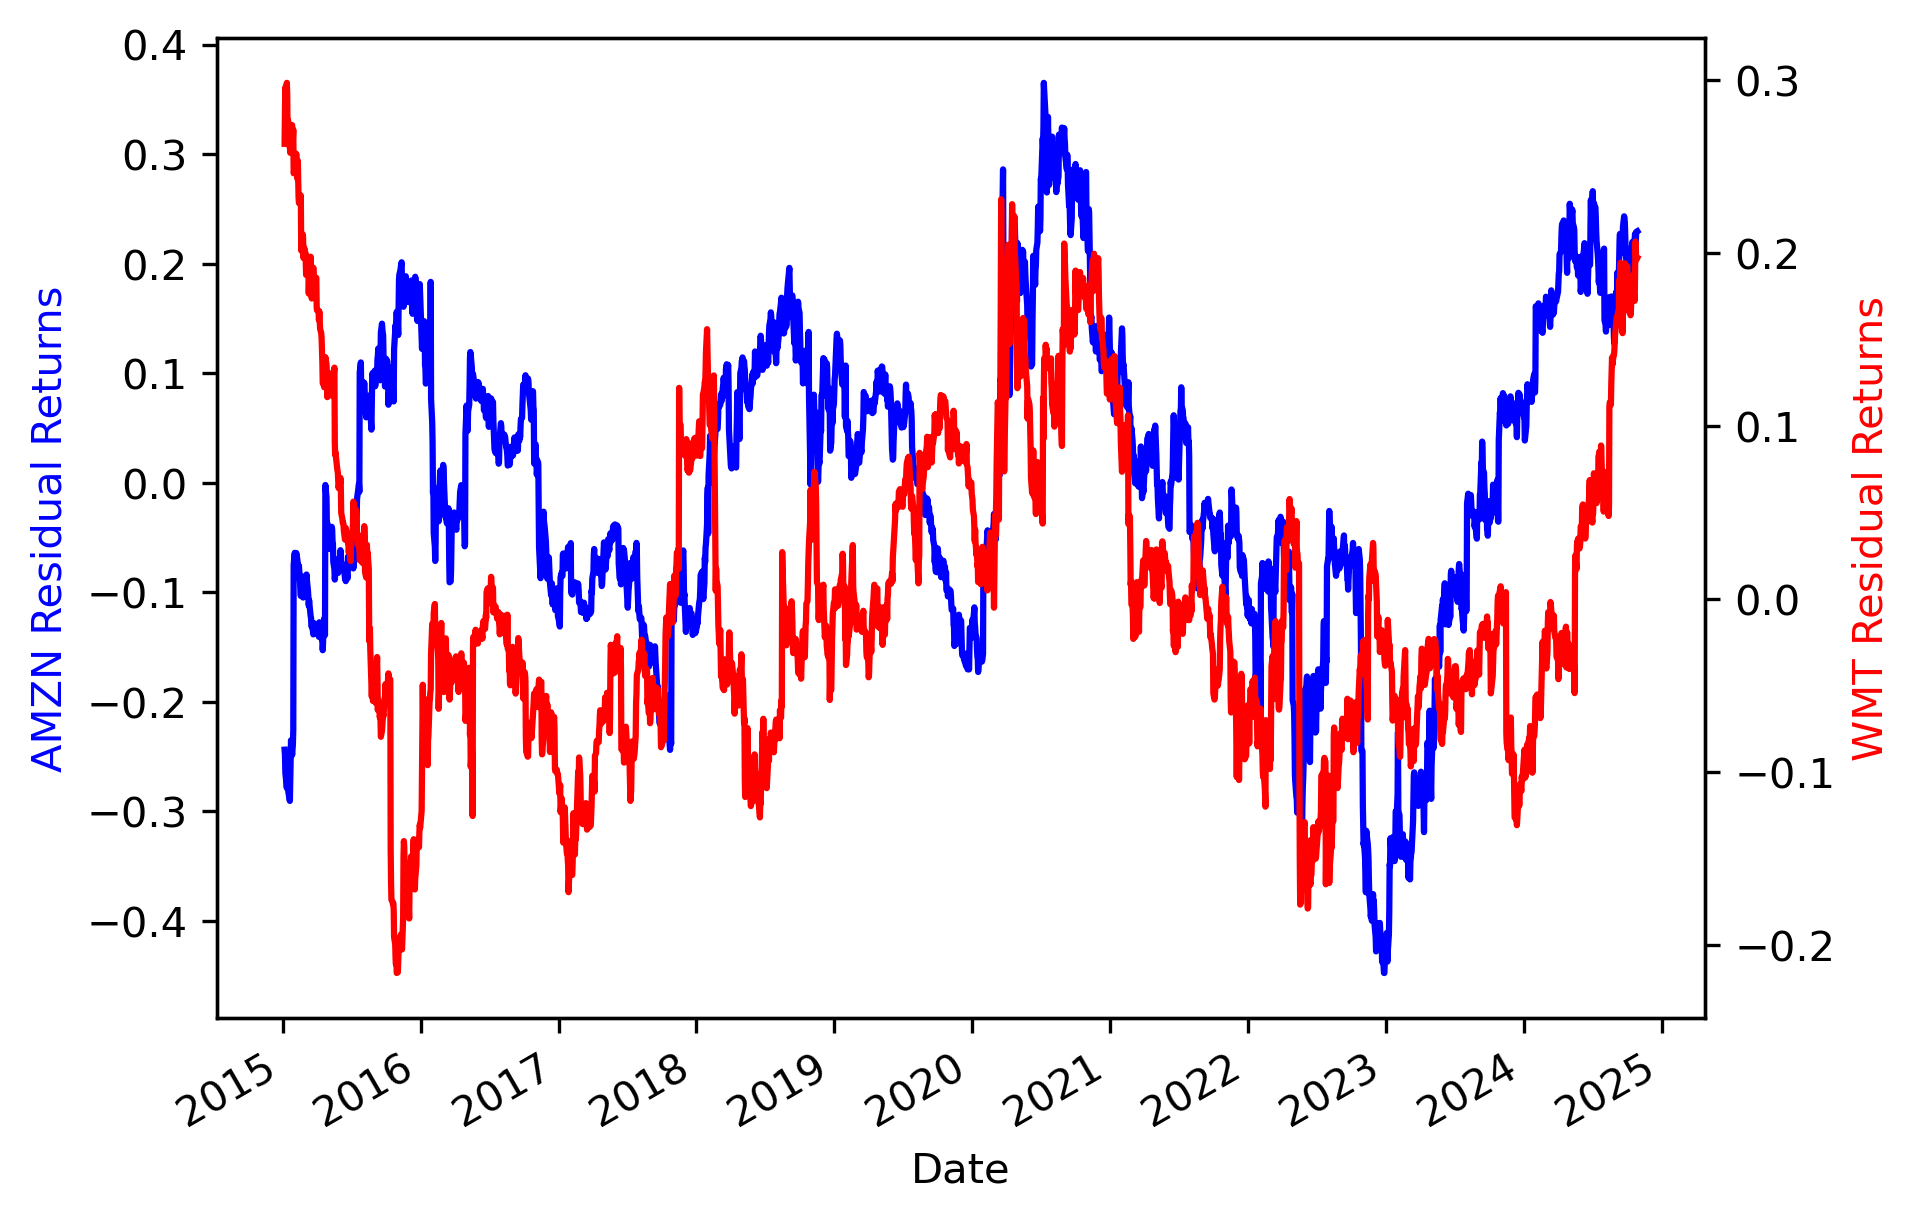

In [451]:
# Create Figure
fig, ax1 = plt.subplots(dpi = 300)

# AMZN Residual Returns
cumsum_detrended['AMZN'].plot(color = 'blue', ax = ax1)
ax1.set_xlabel('Date')
ax1.set_ylabel(
    'AMZN Residual Returns', 
    color='blue'
    )

# WMT Residual Returns
ax2 = ax1.twinx()

cumsum_detrended['WMT'].plot(color = 'red', ax = ax2)
ax2.set_ylabel(
    'WMT Residual Returns', 
    color='red'
    )

plt.show()

In [452]:
# Before 2020: all data up to 2019-12-31
corr_before_2020 = cumsum_detrended['AMZN'].loc[:'2019-12-31'].corr(
    cumsum_detrended['WMT'].loc[:'2019-12-31'])

# After 2020: all data from 2020-01-01 onwards
corr_after_2020 = cumsum_detrended['AMZN'].loc['2020-01-01':].corr(
    cumsum_detrended['WMT'].loc['2020-01-01':])

print(f"The correlation between AMZN and WMT before 2020: {corr_before_2020}")
print(f"The correlation between AMZN and WMT after 2020: {corr_after_2020}")

The correlation between AMZN and WMT before 2020: -0.42557581897673885
The correlation between AMZN and WMT after 2020: 0.6299334979153631


In [453]:
# Calculate Rolling Correlation

rolling_corr_252d_cumsum = cumsum_detrended['AMZN'].rolling(window=252).corr(cumsum_detrended['WMT'])
rolling_corr_252d = capm_residuals['AMZN'].rolling(window=252).corr(capm_residuals['WMT'])

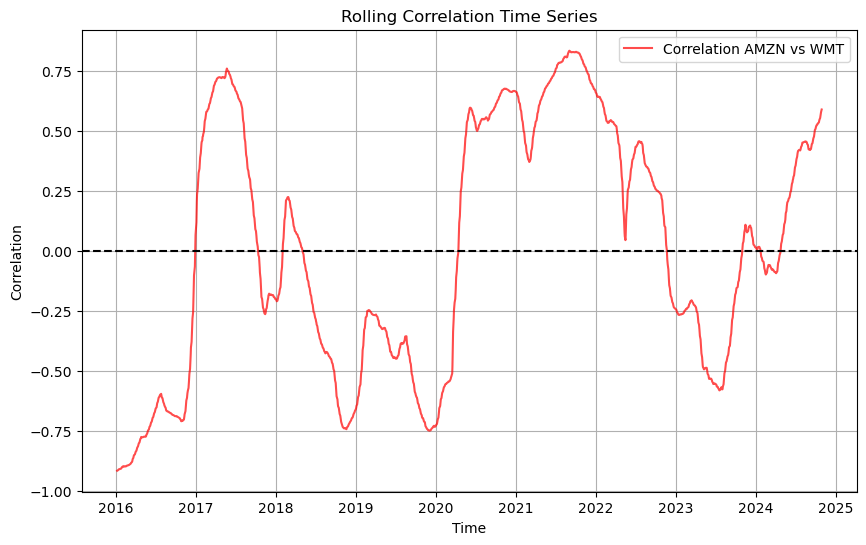

In [454]:
# Plot Residuals

# Crear el gráfico de la serie de tiempo y las medias móviles exponenciales
plt.figure(figsize=(10, 6))
plt.plot(rolling_corr_252d_cumsum, label='Correlation AMZN vs WMT', color='red', alpha=0.7)
plt.axhline(y=0, color='black', linestyle='dashed')

# Añadir título y etiquetas
plt.title('Rolling Correlation Time Series')
plt.xlabel('Time')
plt.ylabel('Correlation')
plt.legend()
plt.grid()

# Mostrar el gráfico
plt.show()

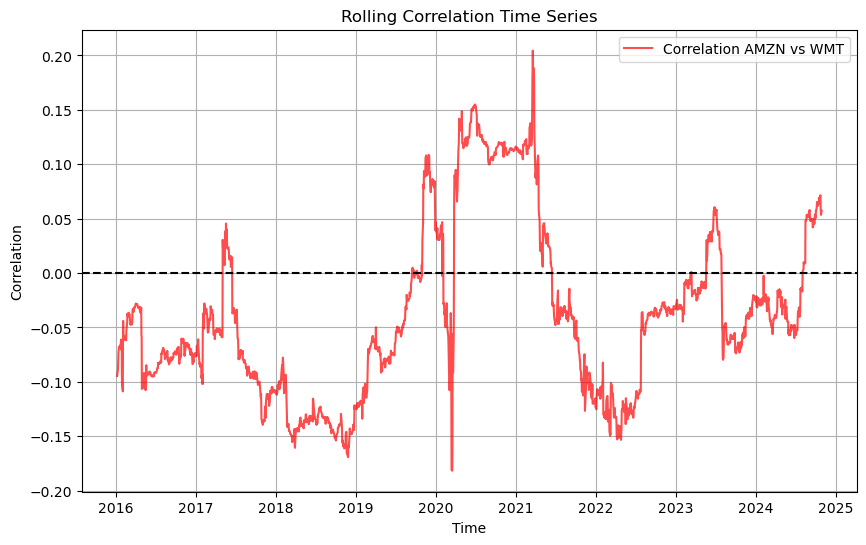

In [455]:
# Plot Residuals

# Crear el gráfico de la serie de tiempo y las medias móviles exponenciales
plt.figure(figsize=(10, 6))
plt.plot(rolling_corr_252d, label='Correlation AMZN vs WMT', color='red', alpha=0.7)
plt.axhline(y=0, color='black', linestyle='dashed')

# Añadir título y etiquetas
plt.title('Rolling Correlation Time Series')
plt.xlabel('Time')
plt.ylabel('Correlation')
plt.legend()
plt.grid()

# Mostrar el gráfico
plt.show()

In [456]:
def portfolio_variance(
    weights, 
    returns
):
    weights = np.array(weights)
    if isinstance(returns, pd.DataFrame):
        returns = returns.values
    
    cov_matrix = np.cov(returns.T)  # matriz de varianzas-covarianzas
    port_var = weights.T @ cov_matrix @ weights
    return port_var

In [457]:
# Create the portfolio
portfolio_df = df_returns[['AMZN', 'WMT']]
weights = [0.5, 0.5]

port_var = portfolio_variance(
    weights,
    portfolio_df
)

port_var

0.0001858112320755783

In [458]:
def rolling_portfolio_variance(returns_df, weights, window=252):
    weights = np.array(weights)

    rolling_vars = []
    index = returns_df.index

    for i in range(window - 1, len(returns_df)):
        window_returns = returns_df.iloc[i - window + 1 : i + 1]
        cov_matrix = np.cov(window_returns.T)
        var = weights.T @ cov_matrix @ weights
        rolling_vars.append(var)

    result = pd.Series([np.nan] * (window - 1) + rolling_vars, index=index)
    return result


In [493]:
# Calculamos la varianza rolling
rolling_var = rolling_portfolio_variance(portfolio_df, weights)
rolling_var = rolling_var * 100

rolling_var.dropna()

Date
2016-01-04    0.018852
2016-01-05    0.018816
2016-01-06    0.018790
2016-01-07    0.018699
2016-01-08    0.018699
                ...   
2024-10-22    0.012967
2024-10-23    0.012941
2024-10-24    0.012873
2024-10-25    0.012488
2024-10-28    0.012427
Length: 2220, dtype: float64

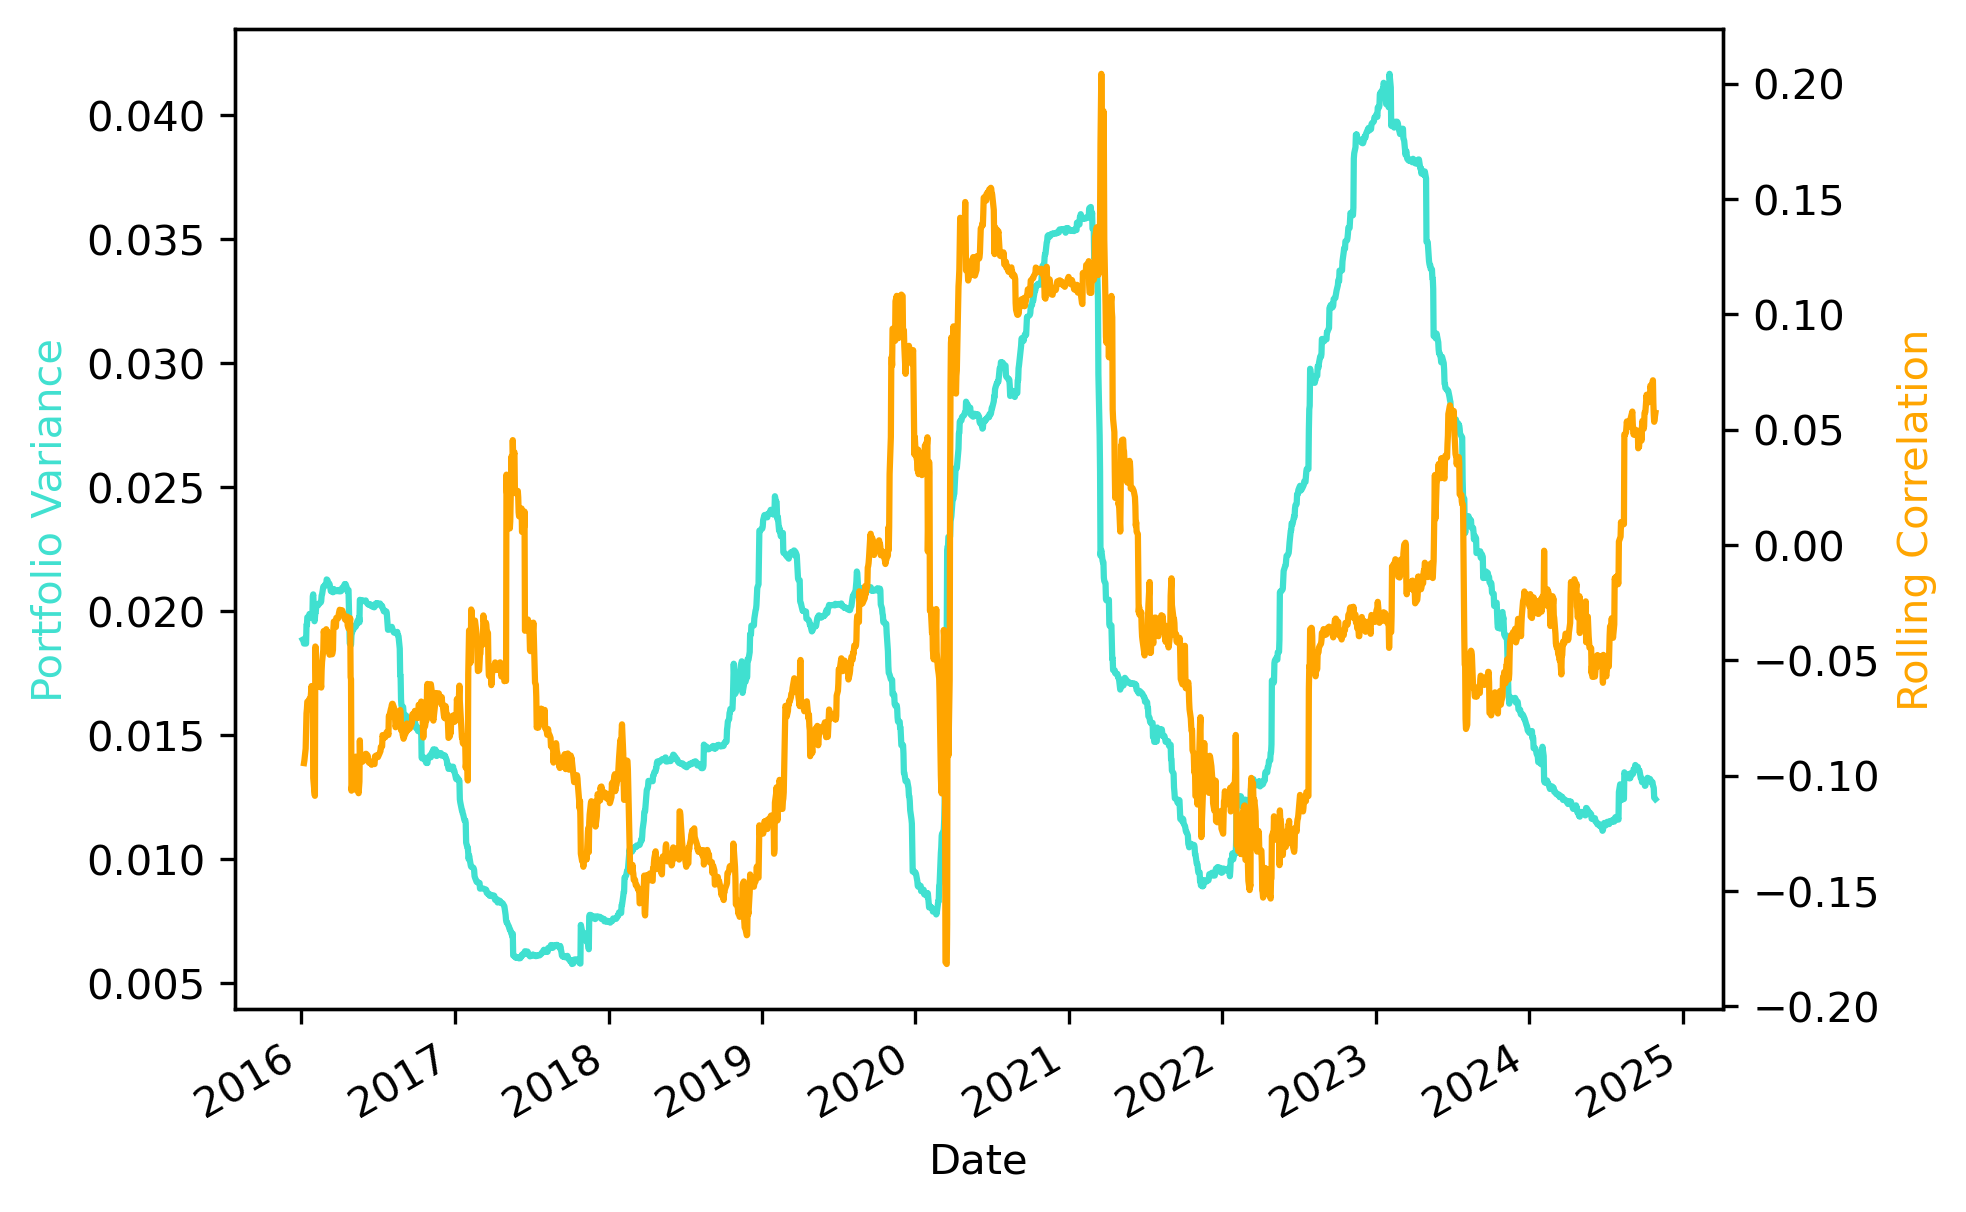

In [498]:
# Create Figure
fig, ax1 = plt.subplots(dpi = 300)

# Potfolio Variance
rolling_var.dropna().plot(color = 'turquoise', ax = ax1)
ax1.set_xlabel('Date')
ax1.set_ylabel(
    'Portfolio Variance', 
    color='turquoise'
    )

# Rolling Correlation
ax2 = ax1.twinx()

rolling_corr_252d.plot(color = 'orange', ax = ax2)
ax2.set_ylabel(
    'Rolling Correlation', 
    color='orange'
    )

plt.show()